# Covid19 Analysis for Recovery Phase Prediction

Source Datasets:

1. Our World in Data COVID-19 Testing dataset https://ourworldindata.org/coronavirus-testing
1. Google Covid19 Community Mobility Reports https://www.google.com/covid19/mobility/

Methdology:

1. Calculate Start of Impact of Covid in a country with 1 case per million population
1. Plot the line chart for 1. Most Affected, 2. Least Affected and 3.USA+some other more affected countries.
1. Observe that in most countries Covid is getting to manageable levels in 90-100 days from impact date. Some countries are different like India, Iran, but overall they should follow the same pattern only taking a bit longer than other countries.

TODO: #rolling average of new cases may smoothen the graphs presented.

In [1]:
#load coviddata dataset
import pandas as pd
url="https://covid.ourworldindata.org/data/owid-covid-data.csv"
coviddata=pd.read_csv(url)
coviddata = coviddata[coviddata['date']>='2020-03-01']

#change data types and column names
coviddata['date'] = pd.to_datetime(coviddata['date'])
coviddata['total_cases_per_million'] = pd.to_numeric(coviddata['total_cases_per_million'])
coviddata.rename(columns={'iso_code':'iso3_code'}, inplace=True)

#filter out negative values
coviddata = coviddata[coviddata.new_cases >= 0]
coviddata = coviddata[coviddata.new_deaths >= 0]

#filter out 'world' and 'international' data
coviddata = coviddata[coviddata.location != 'World']
coviddata = coviddata[coviddata.location != 'International']

display(coviddata)

,iso3_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
61,AFG,Asia,Afghanistan,2020-03-01,1,0,0,0,0.026,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
62,AFG,Asia,Afghanistan,2020-03-02,1,0,0,0,0.026,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
63,AFG,Asia,Afghanistan,2020-03-08,4,3,0,0,0.103,0.077,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
64,AFG,Asia,Afghanistan,2020-03-11,7,3,0,0,0.180,0.077,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
65,AFG,Asia,Afghanistan,2020-03-15,10,3,0,0,0.257,0.077,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22641,ZWE,Africa,Zimbabwe,2020-06-05,237,15,4,0,15.946,1.009,0.269,0.0,21000.0,598.0,1.413,0.040,591.0,0.040,tests performed,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
22642,ZWE,Africa,Zimbabwe,2020-06-06,265,28,4,0,17.830,1.884,0.269,0.0,21354.0,354.0,1.437,0.024,547.0,0.037,tests performed,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
22643,ZWE,Africa,Zimbabwe,2020-06-07,279,14,4,0,18.772,0.942,0.269,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
22644,ZWE,Africa,Zimbabwe,2020-06-08,282,3,4,0,18.973,0.202,0.269,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7


In [2]:
# Assumption Covid started impacting the country when total_cases_per_million population > 1
# Similar assumption can be made it ended when there were less than x amount of new cases per million of population.
Covid_Impact_Date = coviddata

Covid_Impact_Date = Covid_Impact_Date[Covid_Impact_Date.total_cases_per_million >= 1]

Covid_Impact_Date_Agg = Covid_Impact_Date.groupby([Covid_Impact_Date.iso3_code]).agg({'date':'min'}).reset_index()

Covid_Impact_Date_Agg = Covid_Impact_Date_Agg.rename(columns={"date": "impact_date"}, errors="raise")

display(Covid_Impact_Date_Agg)


,iso3_code,impact_date
0,ABW,2020-03-13
1,AFG,2020-03-24
2,AGO,2020-05-03
3,AIA,2020-03-27
4,ALB,2020-03-10
...,...,...
203,VNM,2020-03-23
204,YEM,2020-05-09
205,ZAF,2020-03-17
206,ZMB,2020-03-29


In [3]:
#join datasets for covid_impact_date

master = pd.merge(coviddata, Covid_Impact_Date_Agg, on="iso3_code")

master['covid_day'] = (master['date'] - master['impact_date']).dt.days

# filter out dates  before covid impact (negative covid_day values)
master = master[master.covid_day >= 0]

master

,iso3_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,impact_date,covid_day
13,AFG,Asia,Afghanistan,2020-03-24,40,6,1,1,1.028,0.154,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.37,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,2020-03-24,0
14,AFG,Asia,Afghanistan,2020-03-25,42,2,1,0,1.079,0.051,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.70,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,2020-03-24,1
15,AFG,Asia,Afghanistan,2020-03-26,75,33,1,0,1.927,0.848,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.70,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,2020-03-24,2
16,AFG,Asia,Afghanistan,2020-03-27,75,0,1,0,1.927,0.000,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.70,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,2020-03-24,3
17,AFG,Asia,Afghanistan,2020-03-28,91,16,2,1,2.338,0.411,0.051,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.04,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,2020-03-24,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18346,ZWE,Africa,Zimbabwe,2020-06-05,237,15,4,0,15.946,1.009,0.269,0.000,21000.0,598.0,1.413,0.040,591.0,0.040,tests performed,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-04-14,52
18347,ZWE,Africa,Zimbabwe,2020-06-06,265,28,4,0,17.830,1.884,0.269,0.000,21354.0,354.0,1.437,0.024,547.0,0.037,tests performed,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-04-14,53
18348,ZWE,Africa,Zimbabwe,2020-06-07,279,14,4,0,18.772,0.942,0.269,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-04-14,54
18349,ZWE,Africa,Zimbabwe,2020-06-08,282,3,4,0,18.973,0.202,0.269,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,2020-04-14,55


In [32]:
# attempting to get rolling average of new_cases
# window 
# check result, source should be in the correct order to do so.

#subset
my_subset = master[['iso3_code','location','date','covid_day','new_cases']] #.reset_index()
#display(my_subset)

# compute values for columns E, F, and G
df_ = my_subset.loc[:, ['new_cases']]
numerator = df_.fillna(0).rolling(window=7, min_periods=7).sum()
denominator = df_.notnull().astype(int).rolling(window=7).sum()

# New DataFrame containing results for columns E, F, and G
new_df = numerator / denominator

#display(new_df)



,new_cases
13,NaN
14,NaN
15,NaN
16,NaN
17,NaN
...,...
18346,12.571429
18347,15.000000
18348,15.000000
18349,14.857143


In [33]:
# final DataFrame
final_df = my_subset[['iso3_code','location','date','covid_day']].join(new_df)
#display(final_df)

,iso3_code,location,date,covid_day,new_cases
13,AFG,Afghanistan,2020-03-24,0,NaN
14,AFG,Afghanistan,2020-03-25,1,NaN
15,AFG,Afghanistan,2020-03-26,2,NaN
16,AFG,Afghanistan,2020-03-27,3,NaN
17,AFG,Afghanistan,2020-03-28,4,NaN
...,...,...,...,...,...
18346,ZWE,Zimbabwe,2020-06-05,52,12.571429
18347,ZWE,Zimbabwe,2020-06-06,53,15.000000
18348,ZWE,Zimbabwe,2020-06-07,54,15.000000
18349,ZWE,Zimbabwe,2020-06-08,55,14.857143


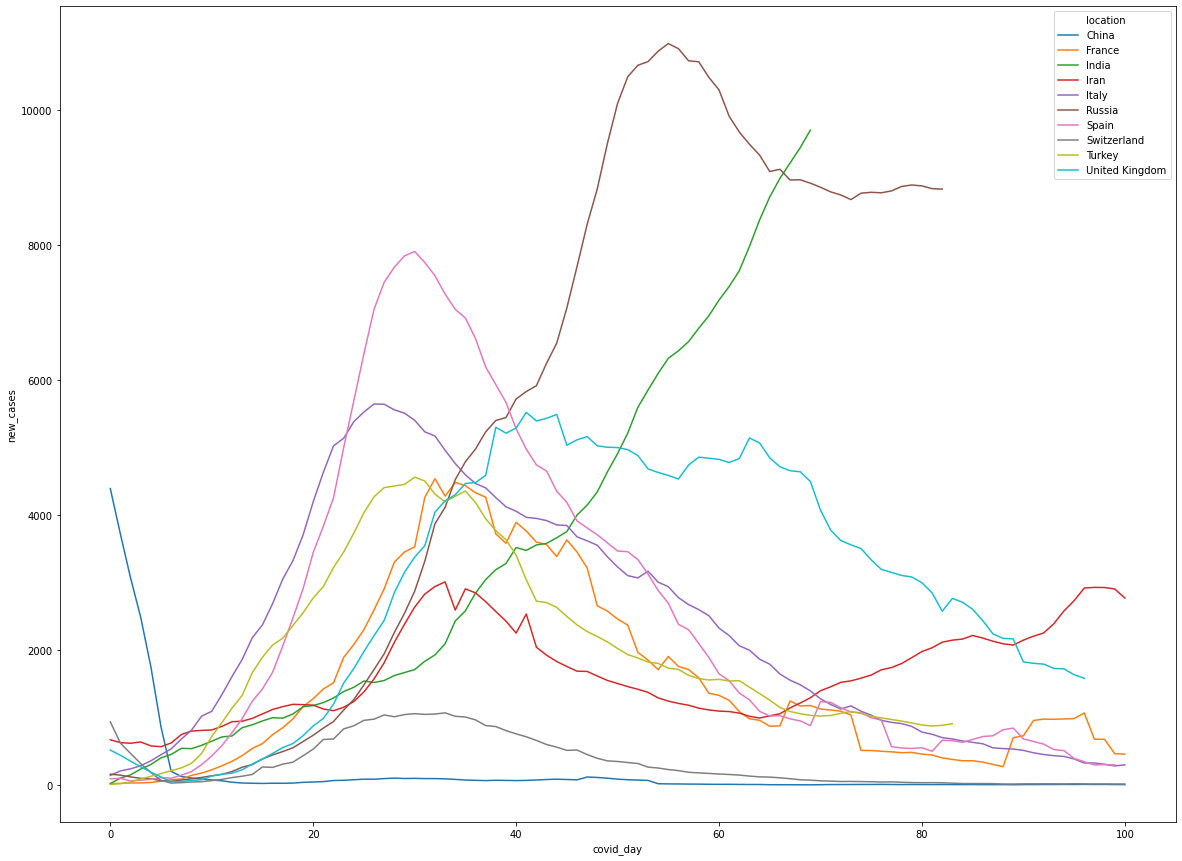

None

In [37]:
#plot new cases by covid_day - most affected countries except USA
#rolling average of new cases may smoothen the graphs presented.

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['CHN', 'FRA', 'IND', 'ITA', 'IRN', 'ESP', 'CHE', 'TUR', 'GBR','RUS']
#master_selection=master[(master['iso3_code'].isin(countrys))]
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]

ax = sns.lineplot(x="covid_day", y="new_cases", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())

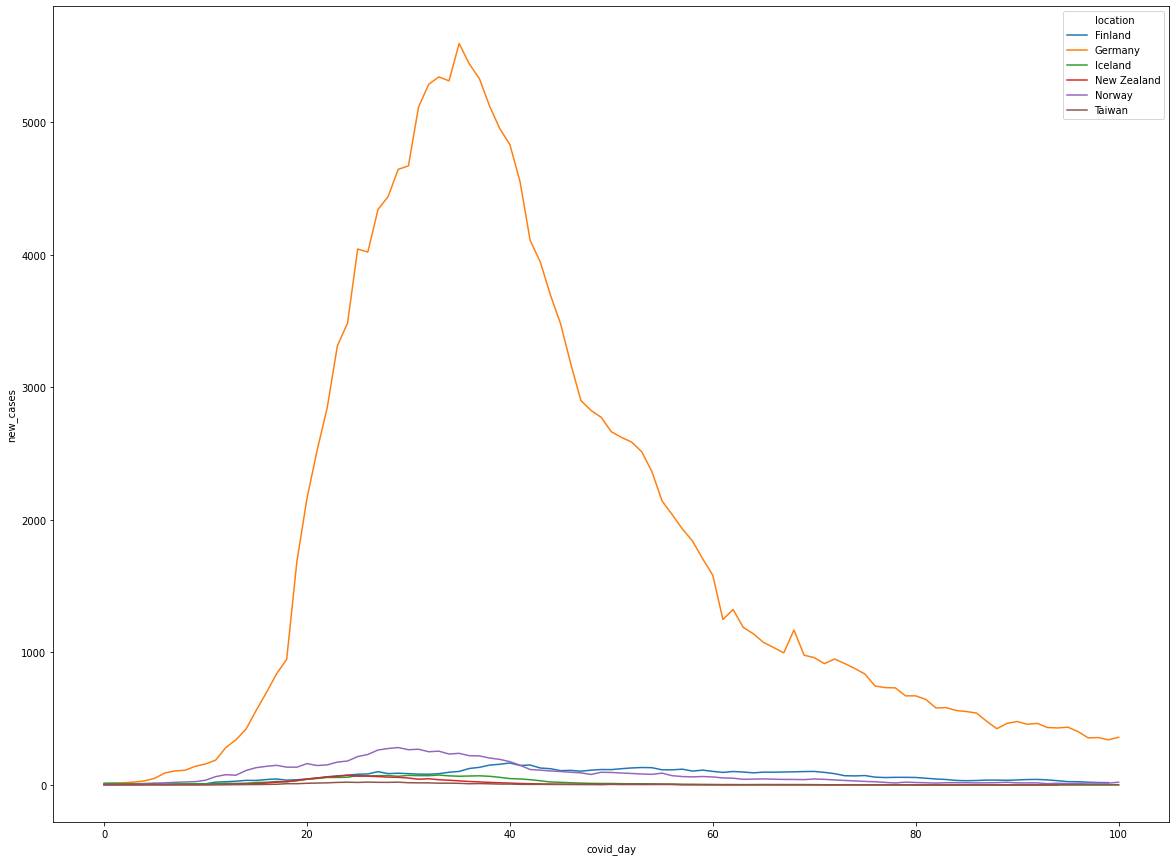

None

In [36]:
#plot new cases by covid_day - least affected countries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['ISL', 'FIN', 'DEU', 'NOR', 'NZL', 'TWN']
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]
#master_selection=master[(master['iso3_code'].isin(countrys))]
ax = sns.lineplot(x="covid_day", y="new_cases", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())

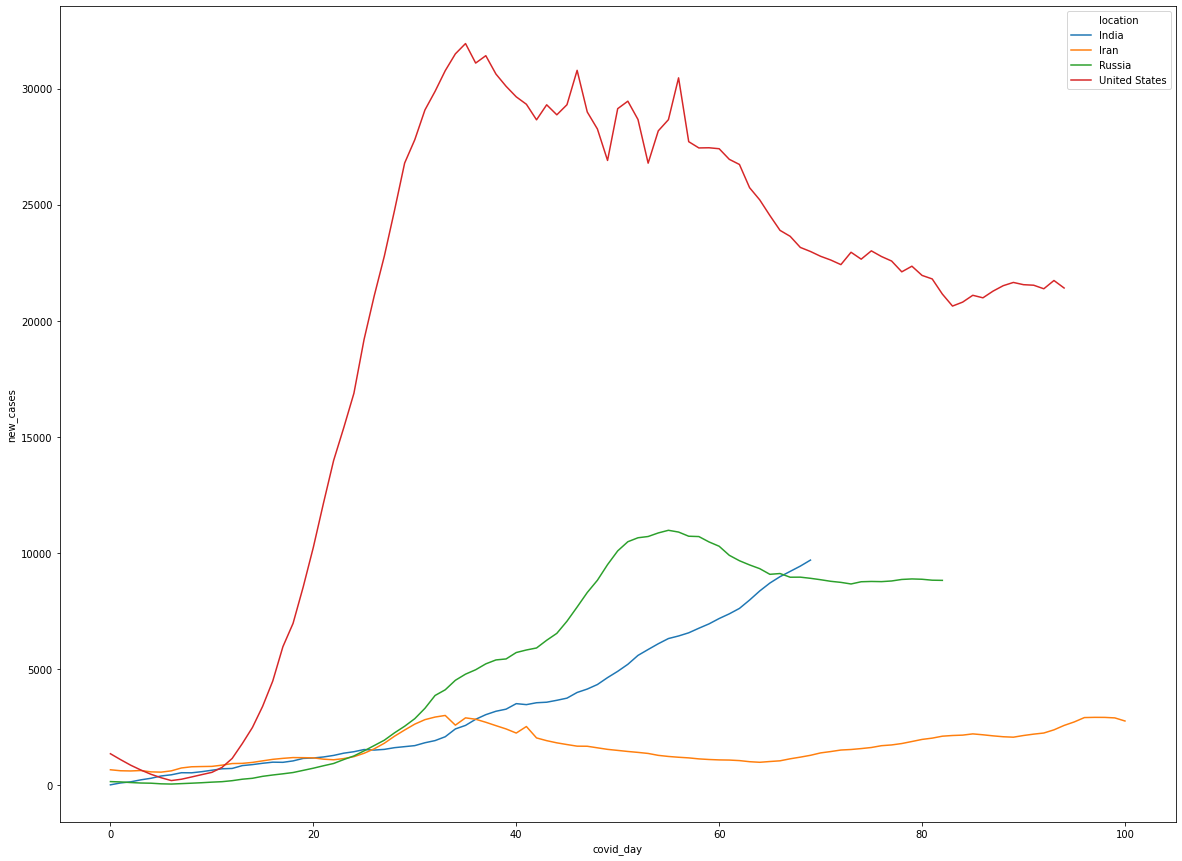

None

In [35]:
#plot new cases by covid_day - USA and Russia
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#plot on residential mobility stats with selected countries 
plt.figure(figsize=(20,15))

countrys=['USA','RUS','IND', 'IRN']
#master_selection=master[(master['iso3_code'].isin(countrys))]
master_selection=final_df[(final_df['iso3_code'].isin(countrys))]
ax = sns.lineplot(x="covid_day", y="new_cases", hue="location", data=master_selection)
#plt.yscale('log')
display(plt.show())